In [1]:
#coding=utf-8
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm
import matplotlib.patches as mpatches
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
import numpy as np
from lasagne import utils


Using cuDNN version 5105 on context None
Mapped name None to device cuda: GeForce GT 740M (0000:01:00.0)


# Prepare Data

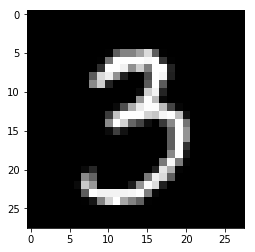

(60000, 1, 28, 28)
3.0


In [2]:
from sklearn.preprocessing import OneHotEncoder

image_w = 18
image_h = 18


data = np.load("mnist.npz")

np.random.seed(1)

X_val, y_val = data["test"].reshape(28,28,-1), data["test_labels"].flatten()
X_train, y_train = data["train"].reshape(28,28,-1), data["train_labels"].flatten()
X_test = X_val.copy()

#prepare
X_val = np.transpose(X_val,(2,0,1)).astype(np.float32)/255.
X_train = np.transpose(X_train,(2,0,1)).astype(np.float32)/255.
X_test = np.transpose(X_test,(2,0,1)).astype(np.float32)/255.


X_train = X_train[:, np.newaxis,:,:]
X_val = X_val[:, np.newaxis,:,:]
X_test = X_test[:, np.newaxis,:,:]
#show
plt.gray()
plt.imshow(X_train[20000,0,:,:])
plt.show()
print(X_train.shape)
print(y_train[20000])

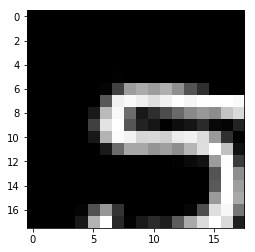

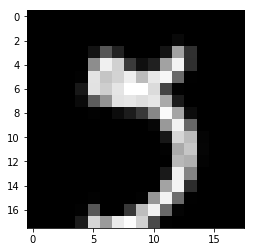

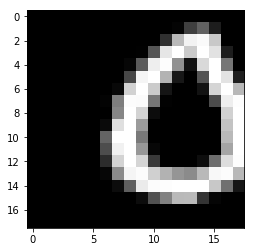

In [3]:
import cv2
from gauss_ll_hist import GaussLLHistModel
import theano.tensor as T
import theano

one_affine = np.array([[1.0,0,0],[0,1,0]],dtype=np.float32)

def affine_transform(im,noise_val=0.1):
    affine = one_affine+(0.5-np.random.rand(2,3))*noise_val
    affine[:,2] = np.random.rand(2)*noise_val*2
    affine[:,:2] /= float(im.shape[0])/float(image_h)
    res = cv2.warpAffine(im,affine,dsize=(image_w,image_h))
    return res

def preprocess(X,noise):
    _X = np.zeros((len(X),1,image_w,image_h),dtype=np.float32)
    for i in range(len(_X)):
        _X[i,0,:,:] = affine_transform(X[i,0,:,:],noise)
    return _X


def data_generator(X, y, batch_size=500, noise=0.4):
    inx = np.arange(0,len(X),dtype=np.int)
    while True:
        digit = np.random.randint(10)
        p_inx = np.random.choice(inx[y == digit], size=batch_size*2)
        n_inx = np.random.choice(inx[y != digit], size=batch_size)
        batch_X = preprocess(X[p_inx[:batch_size]],noise)
        batch_Yp = preprocess(X[p_inx[batch_size:]], noise) 
        batch_Yn = preprocess(X[n_inx], noise)         
        yield batch_X,batch_Yp,batch_Yn

for X,Yp,Yn in data_generator(X_train,y_train,1,0.4):
    plt.gray()
    plt.imshow(X[0,0,:,:])
    plt.show()
    plt.gray()
    plt.imshow(Yp[0,0,:,:])
    plt.show()
    plt.gray()
    plt.imshow(Yn[0,0,:,:])
    plt.show()
    break



In [4]:
gmm = GaussLLHistModel(100,2,150)

In [5]:
from sklearn import mixture

class GMMGradOp(theano.Op):
    def __init__(self, gaussLLHistModel):
        super(GMMGradOp, self).__init__()
        self.gaussLLHistModel = gaussLLHistModel
        self.otypes = [T.fmatrix,T.fmatrix,T.fmatrix]
        self.itypes = [T.fmatrix,T.fmatrix,T.fmatrix]

    def perform(self, node, (x,yp,yn), output_storage):
        dx,dyp,dyn = output_storage[0],output_storage[1],output_storage[2]
        fdx,fdyp,fdyn = self.gaussLLHistModel.backward(x,yp,yn)
        dx[0],dyp[0],dyn[0] = fdx.astype(np.float32),fdyp.astype(np.float32),fdyn.astype(np.float32)
        
        

class GMMOp(theano.Op):
    def __init__(self, gaussLLHistModel):
        super(GMMOp, self).__init__()
        self.gaussLLHistModel = gaussLLHistModel
        self.otypes = [T.scalar]
        self.itypes = [T.fmatrix,T.fmatrix,T.fmatrix]

    def perform(self, node, (x,yp,yn), output_storage):
        z = output_storage[0]
        z[0] = self.gaussLLHistModel.forward(x,yp,yn)
        
    def grad(self, (X,Yp,Yn), output_grads):
        return GMMGradOp(self.gaussLLHistModel)(X,Yp,Yn)
    

def gmm_prob(Y,means,covars,weights):
    d = Y.shape[1]
    prob = (-.5*d*np.log(2*np.pi)-.5*np.log(covars).sum(1))[None,:]\
            -0.5*((Y[:,None,:]-means[None,])**2/covars[None,:,:]).sum(2)\
            +np.log(weights)[None,:]
    return np.exp(prob).sum(1)

def build_gmm(X, gm_num):
    gmm = mixture.GaussianMixture(covariance_type='diag',n_components=gm_num, max_iter=100)
    gmm.fit(X)
    return np.copy(gmm.means_), np.copy(gmm.covariances_), np.copy(gmm.weights_)

def classify(X,Y,gm_num,rate):
    Yll = gmm_prob(Y,*build_gmm(X,gm_num))
    mask = np.zeros_like(Yll)
    mask[Yll > rate] = 1.
    return mask

def accuracy(X,Yp,Yn,gm_num,rate):
    cl = classify(X,np.concatenate((Yp,Yn)),gm_num,rate)
    return (cl[:len(Yp)].sum()+len(Yn)-cl[len(Yp):].sum())/len(cl)


# Build model

In [6]:
from lasagne import layers as L
import theano.tensor as T
import theano
import lasagne
from lasagne.nonlinearities import rectify,softmax

In [7]:
batch_size = 100

def get_net(input_X,input_Yp,input_Yn):
    def conv_unit(data,nf,nonl = rectify):
        res =L.Conv2DLayer(data,nf,(3,3),nonlinearity=None)
        res  =L.BatchNormLayer(res)
        res = L.NonlinearityLayer(res,nonl)  
        return res
    X = L.InputLayer(shape=(batch_size,1, image_h,image_w), input_var=input_X)
    Yp = L.InputLayer(shape=(batch_size,1, image_h,image_w), input_var=input_Yp)
    Yn = L.InputLayer(shape=(batch_size,1, image_h,image_w), input_var=input_Yn)
    res = L.ConcatLayer([X,Yp,Yn],axis=0)
    res = conv_unit(res,6)
    res = L.Pool2DLayer(res,(2,2))
    res = conv_unit(res,12)
    res = L.Pool2DLayer(res,(2,2))
    res = conv_unit(res,24)
    res = L.FlattenLayer(res)
    res = L.DenseLayer(res,20)
    fX = L.SliceLayer(res,slice(0,batch_size),axis=0)
    fYp = L.SliceLayer(res,slice(batch_size,2*batch_size),axis=0)
    fYn = L.SliceLayer(res,slice(batch_size*2,batch_size*3),axis=0)
    return res,fX,fYp,fYn

input_X = T.tensor4('X')
input_Yp = T.tensor4('Yp')
input_Yn = T.tensor4('Yn')
net,fX,fYp,fYn = get_net(input_X,input_Yp,input_Yn)

In [8]:
from theano import tensor as T
from theano.ifelse import ifelse

def calc_log_prob_gauss_vector(Y,means,covars,weights = None):
    n_samples, n_dim = Y.shape
    if(weights is None):
        lpr = (-0.5 * (n_dim * T.log(2 * np.pi) + T.sum(T.log(covars), 1)
                      + T.sum((means ** 2) / covars, 1)
                      - 2 * T.dot(Y, (means / covars).T)
                      + T.dot(Y ** 2, T.transpose(1.0 / covars))))
    else:
        lpr = (-0.5 * (n_dim * T.log(2 * np.pi) + T.sum(T.log(covars), 1)
                      + T.sum((means ** 2) / covars, 1)
                      - 2 * T.dot(Y, (means / covars).T)
                      + T.dot(Y ** 2, T.transpose(1.0 / covars))) + T.log(weights))
    lpr = T.transpose(lpr, (1,0))
    vmax = T.max(lpr,axis=0)
    out = T.log(T.sum(T.exp(lpr- vmax), axis=0))
    out += vmax
    return out

def histogram_loss(p_n, p_p,min_cov,bin_num): 
    '''
    p_n -- negative values (theano vector)
    p_p -- positive values (theano vector)
    min_cov -- python float
    bin_num -- python int
    '''
    def calc_hist_vals_vector_th(p, hmn, hmax):
        sample_num = p.shape[0]
        p_mat = T.tile(p.reshape((sample_num, 1)), (1, bin_num))
        w = (hmax - hmn) / bin_num + min_cov
        grid_vals = T.arange(0, bin_num)*(hmax-hmn)/bin_num+hmn+w/2.0
        grid = T.tile(grid_vals, (sample_num, 1))
        w_triang = 4 * w + min_cov
        D = T._tensor_py_operators.__abs__(grid-p_mat)
        mask = (D<=w_triang/2)
        D_fin = w_triang * (D*(-2.0 / w_triang ** 2) + 1.0 / w_triang)*mask
        hist_corr = T.sum(D_fin, 0)
        return hist_corr
    
    def hist_loss(hn, hp):
        scan_result, scan_updates = theano.scan(fn = lambda ind, A: T.sum(A[0:ind+1]),
                    outputs_info=None,
                    sequences=T.arange(bin_num),
                    non_sequences=hp)
        agg_p = scan_result
        L = T.sum(T.dot(agg_p, hn))
        return L
    
    def calc_min_max(p_n, p_p):
        hminn = T.min(p_n)
        hmaxn = T.max(p_n)
        hminp = T.min(p_p)
        hmaxp = T.max(p_p)
        hmin = ifelse(T.lt(hminp,hminn), hminp, hminn)
        hmax = ifelse(T.lt(hmaxp, hmaxn), hmaxn, hmaxp)
        return hmax, hmin
    
    hmax, hmin = calc_min_max(p_n, p_p)
    hmin -= min_cov
    hmax += min_cov
    hp = calc_hist_vals_vector_th(p_p, hmin, hmax)
    hn = calc_hist_vals_vector_th(p_n, hmin, hmax)
    L = hist_loss(hn, hp)
    return L, hmax, hmin, hn, hp
    

# Load weights

In [9]:

def save_weights(network, name ):
    np.savez(name+".npz", **{"param%d" % i: param for i, param in enumerate(L.get_all_param_values(network))})
             
def load_weights(network,name ):
    f = np.load(name+".npz")
    params = [f["param%d" % i] for i in range(len(f.files))]
    f.close()
    L.set_all_param_values(network,params)
    
load_weights(net,'weights3')

In [10]:

params = lasagne.layers.get_all_params(net, trainable=True)

outX = lasagne.layers.get_output(fX)
outX = outX/T.sqrt(T.square(outX).sum(1)[:,None])

outYp = lasagne.layers.get_output(fYp)
outYp = outYp/T.sqrt(T.square(outYp).sum(1)[:,None])

outYn = lasagne.layers.get_output(fYn)
outYn = outYn/T.sqrt(T.square(outYn).sum(1)[:,None])

mean = T.mean(outX,axis=0).reshape((1,-1))
covars = (T.std(outX,axis=0)+0.0001).reshape((1,-1))

p_p = calc_log_prob_gauss_vector(outYp,mean,covars)
p_n = calc_log_prob_gauss_vector(outYn,mean,covars)

loss = GMMOp(gmm)(outX,outYp,outYn)#histogram_loss(p_n,p_p,0.0001,200)[0]#

G_lr = theano.shared(np.array(0.0001, dtype=theano.config.floatX))
updates = lasagne.updates.adam(loss,params,G_lr)


In [11]:
train_fn = theano.function([input_X, input_Yp,input_Yn], [loss], allow_input_downcast=True, updates=updates)
print 'train_fn compiled'
test_fn  = theano.function([input_X, input_Yp,input_Yn],[outX,outYp,outYn], allow_input_downcast=True)
print 'test_fn compiled'

train_fn compiled
test_fn compiled


In [12]:
G_lr.set_value(np.float32(0.00001))

In [13]:
import warnings
warnings.filterwarnings('ignore')

In [23]:
for j in range(0,1000):
    train_loss=0
    for i,batch in enumerate(data_generator(X_train,y_train,batch_size)):
        res = train_fn(*batch)
        train_loss+=res[0]
        print '\r epoch %i batch %i loss=%.2f'%(j,i,train_loss/float(i+1)),
        if(i == 100):
            break
    print ''

 epoch 0 batch 100 loss=293.06                                                
 epoch 1 batch 100 loss=317.34                                                
 epoch 2 batch 100 loss=310.20                                                 
 epoch 3 batch 100 loss=311.31                                                
 epoch 4 batch 100 loss=309.68                                                 
 epoch 5 batch 100 loss=309.61                                                 
 epoch 6 batch 100 loss=272.03                                                
 epoch 7 batch 100 loss=325.20                                                
 epoch 8 batch 100 loss=344.24                                                
 epoch 9 batch 100 loss=316.05                                                 
 epoch 10 batch 100 loss=268.62                                                
 epoch 11 batch 100 loss=285.72                                                 
 epoch 12 batch 100 loss=316.80              

KeyboardInterrupt: 

In [61]:
x,xp,xn = test_fn(*batch)
means,covars,weights,_ = gmm.build_gmm(x,min_cov=0.0001)
res = gmm.f(xp.flatten(),means.flatten(),covars.flatten(),weights.flatten())

In [62]:
print res.max()

25.1155986807


In [24]:
test_loss=0
for i,batch in enumerate(data_generator(X_train,y_train,batch_size)):
    res = test_fn(*batch)
    test_loss+=accuracy(*res,gm_num=2,rate=100000)
    print '\r ebatch %i loss=%.2f'%(i,test_loss/float(i+1)),
    if(i == 30):
        break
print ''

 ebatch 30 loss=0.96   


# Save model

In [29]:
save_weights(net,'weights3')